# Quantitative analysis of single glacier run
This notebooks computes equilibrium values, e-folding time scales, and more from the data of the single glacier test case experiment. The values are used in Chapter 3, Section 1: **Single glacier test case**. It is limited to the Hintereisferner (RGI60-11.00897), but all other *showcase glaciers* could also be investigated...

In [1]:
# import section
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

**Aux functions**

In [16]:
def rel_dif(a,b):
    """Compute relative difference between a and b"""
    return abs(a-b)/((a+b)/2)

# test
i = 4.89
p = 5.26
n = 4.52
assert(rel_dif(abs(i-n),abs(i-p)) == 0)

**Read the dataset**

In [2]:
def read_dataset(path):
    # read dataset
    ds = xr.load_dataset(path)
    # sort by temperature bias
    ds = ds.sortby('temp_bias')
    # cast normalized dimension from int to bool
    ds['normalized'] = [bool(norm) for norm in ds.normalized]

    return ds

In [52]:
# read dataset
path = '/Users/oberrauch/work/master/data/cluster_output/single_glaciers/eq_runs.nc'
ds = read_dataset(path)
# select Hintereisferner
ds = ds.sel(rgi_id='RGI60-11.00897')

In [59]:
pd.read_csv('/Users/oberrauch/work/master/data/showcase_glaciers.csv')

,rgi_id,name
0,RGI60-11.00897,Hintereisferner
1,RGI60-11.00106,Pasterze
2,RGI60-11.03643,Mer de Glace
3,RGI60-11.03638,Glacier d'Argentière
4,RGI60-11.01450,Großer Aletschgletscher
5,RGI60-11.01238,Rhonegletscher


**Correlation between VAS model and flowline model under random climate**

In [4]:
# define parameters and variables of interest
variables = ['volume', 'area', 'length',]
mb_m = 'random'
n = True
r_data = list()
p_data = list()
# iterate over all 
for var in variables:
    r_data_ = list()
    p_data_ = list()
    for b in ds.temp_bias.values:
        # select volume from dataset by temperature bias and geometric variable
        time_slice = slice(0,1000)
        ds_sel = ds.sel(mb_model=mb_m, normalized=n, temp_bias=b).isel(time=time_slice)[var]
        # compute correlation and add to container
        r, p = pearsonr(ds_sel.sel(model='vas'), ds_sel.sel(model='fl'))
        r_data_.append(r)
        p_data_.append(p)
    r_data.append(r_data_)
    p_data.append(p_data_)
    
# convert into dataframes
df_r = pd.DataFrame(r_data, index=variables, columns=ds.temp_bias.values)
df_p = pd.DataFrame(p_data, index=variables, columns=ds.temp_bias.values)

Compute and show range of $r$- and $p$-values

In [5]:
# Pearson correlation coefficient
df_r

,-0.5,0.0,0.5
volume,0.351847,0.583906,0.406146
area,0.336697,0.475724,0.350043
length,0.529037,0.520428,0.582786


In [9]:
print(f'Minimum correlation: {df_r.min().min():.3f}')
print(f'Minimum correlation: {df_r.max().max():.3f}')

Minimum correlation: 0.337
Minimum correlation: 0.584


In [10]:
# two-sided p value
df_p

,-0.5,0.0,0.5
volume,1.632241e-30,1.890370e-92,5.305373e-41
area,6.256902e-28,1.310603e-57,3.372926e-30
length,3.330477e-73,1.705035e-70,5.087519e-92


In [12]:
print(f'Minimum p-value: {df_p.min().min():.2e}')
print(f'Minimum p-value: {df_p.max().max():.2e}')

Minimum p-value: 1.89e-92
Minimum p-value: 6.26e-28


Create scatter plots

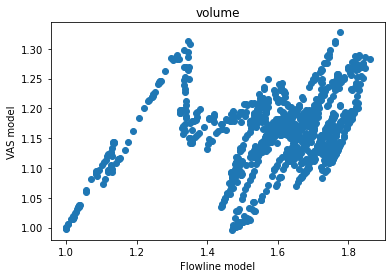

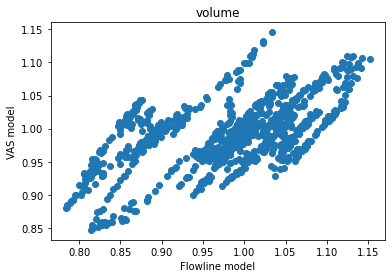

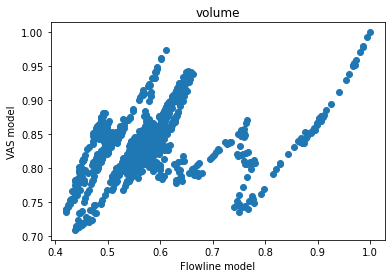

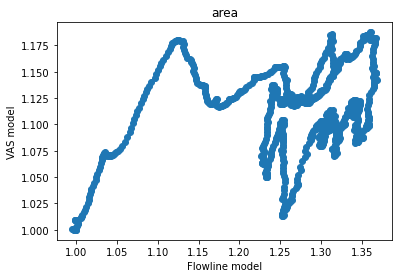

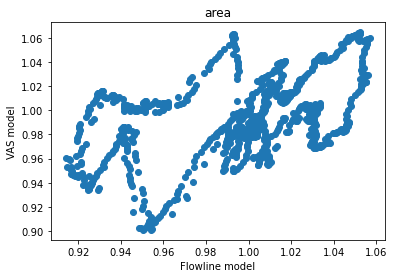

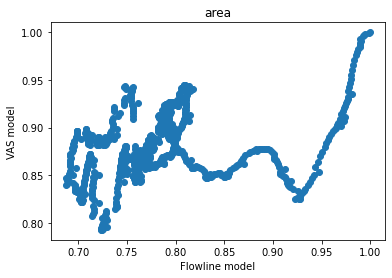

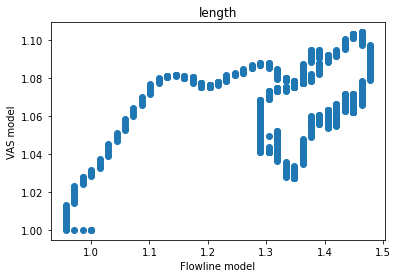

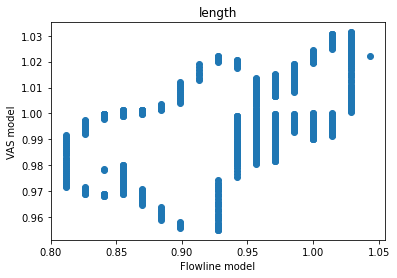

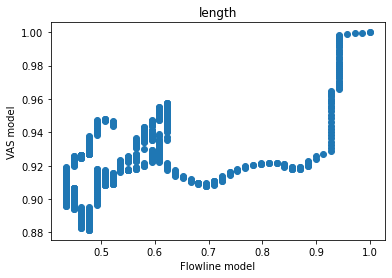

In [14]:
variables = ['volume', 'area', 'length',]
mb_m = 'random'
n = True
data = list()
for var in variables:
    for b in ds.temp_bias.values:
        # clip some data if necessary
        time_slice = slice(0,1000)
        # select variable from dataset by temperature bias and geometric variable
        ds_sel = ds.sel(mb_model=mb_m, normalized=n, temp_bias=b).isel(time=time_slice)[var]
        plt.figure()
        plt.scatter(ds_sel.sel(model='fl'), ds_sel.sel(model='vas'))
        plt.title(var)
        plt.xlabel('Flowline model')
        plt.ylabel('VAS model')

**Response times $\tau$**

In [15]:
# define parameters and variables of interest
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
# iterate over all
for var in variables:
    data_ = list()
    for m in ds.model.values:
        data__ = list()
        for b in temp_biases:
            # select variable by model and temperature bias
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            vol = ds_sel.sel(normalized=1)[var]
            # compute equilibrium value
            vol_eq = vol.isel(time=-1)
            # compute absolute value change
            vol_eq_dif = np.abs(vol_eq - vol.isel(time=0))
            # compute difference between yearly volume and equilibrium volume
            vol_dif = np.abs(vol_eq - vol)
            # compute e-folding time (much rather find index)
            # and add to container
            tau = int(vol.where(vol_dif < vol_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values)
            data__.append(tau)
        data_.extend(data__)
    data.append(data_)

# create dataframe
tau = pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(ds.model.values, 2),
                                                                    np.tile(temp_biases, 2)))),
                   index=variables)
tau

vas        fl     
       -0.5  0.5 -0.5  0.5
volume   24   22  142   80
area     36   33  160  111
length   55   52  184  118

Look at symmetry of time scales

In [18]:
# compute relative difference in tau between pos and neg temperature bias
for var, row in tau.iterrows():
    rd = rel_dif(row['vas'][-0.5], row['vas'][+0.5])
    print('VAS {}: {:.2f}'.format(var, rd))
    rd = rel_dif(row['fl'][-0.5], row['fl'][+0.5])
    print('FL {}: {:.2f}'.format(var, rd))

VAS volume: 0.09
FL volume: 0.56
VAS area: 0.09
FL area: 0.36
VAS length: 0.06
FL length: 0.44


**Equilibrium values**

Compute fluctuations of the equilibrium value over the last 200 years of the simulation. This is done by computing the  relative difference (see above) between minimum and maximum value in that period. The table shows the results in percent.

In [19]:
var = ''
data = list()
variables = ['volume', 'area', 'length',]
models = ['vas', 'fl']
temp_biases = [+0.5, -0.5]
for var in variables:
    data_ = list()
    for m in models:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b, normalized=True).isel(time=slice(-200, None))[var]
            
            rd = rel_dif(min(ds_sel).values, max(ds_sel).values)
            data__.append(f'{rd*100:.2f}%')
        data_.extend(data__)
    data.append(data_)
    
columns = pd.MultiIndex.from_tuples(list(zip(np.tile(temp_biases, 2),
                                             np.repeat(models, 2))))

eq_fluctuations = pd.DataFrame(data, index=variables, columns=columns).T.sort_index(level=0, sort_remaining=False, ascending=True)
eq_fluctuations.T

-0.5           0.5       
          vas     fl    vas     fl
volume  0.00%  0.02%  0.00%  0.00%
area    0.00%  0.03%  0.00%  0.01%
length  0.00%  0.00%  0.00%  0.00%

Compute new equilibrium values for runs with temperature perturbation. Table shows absolute and relative values.

In [29]:
var = ''
data = list()
variables = ['volume', 'area', 'length',]
models = ['vas', 'fl']
temp_biases = [+0.5, -0.5]
for var in variables:
    data_ = list()
    for m in models:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            avg_abs = ds_sel.sel(normalized=False, time=1000)[var].values
            avg_norm = ds_sel.sel(normalized=True, time=1000)[var].values
            data__.append('{:.2e} ({:.0f}%)'.format(avg_abs, avg_norm*1e2))
        data_.extend(data__)
    data.append(data_)
    
columns = pd.MultiIndex.from_tuples(list(zip(np.tile(temp_biases, 2),
                                             np.repeat(models, 2))))

eq_values = pd.DataFrame(data, index=variables, columns=columns).T.sort_index(level=0, sort_remaining=False, ascending=True)
eq_values.T

-0.5                              0.5                
                    vas               fl             vas              fl
volume  6.95e+08 (117%)  1.38e+09 (172%)  5.04e+08 (85%)  4.62e+08 (58%)
area    8.98e+06 (112%)  1.06e+07 (133%)  7.12e+06 (89%)  6.16e+06 (77%)
length  5.25e+03 (107%)  9.80e+03 (142%)  4.54e+03 (93%)  3.80e+03 (55%)

Compute maximum year-to-year length variation estimated by the VAS model

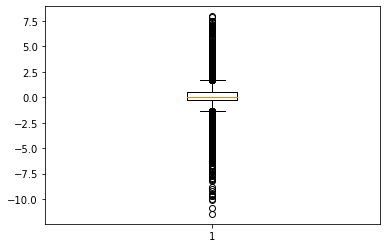

In [22]:
vas_length = ds.sel(model='vas', normalized=False).length
plt.boxplot(vas_length.diff(dim='time').values.flatten());

In [23]:
pd.DataFrame(vas_length.diff(dim='time').values.flatten()).describe()

,0
count,6.000000e+03
mean,3.925596e-02
std,1.876294e+00
min,-1.146011e+01
25%,-2.223657e-01
50%,2.799470e-08
75%,5.305154e-01
max,7.971097e+00


In [24]:
max_dl = abs(vas_length.diff(dim='time').values).flatten().max()
print(f'Maximum year-to-year length change: {max_dl:.0f} m')

Maximum year-to-year length change: 11 m


Get HEF length records and take a look...

In [2]:
from oggm import utils

<AxesSubplot:>

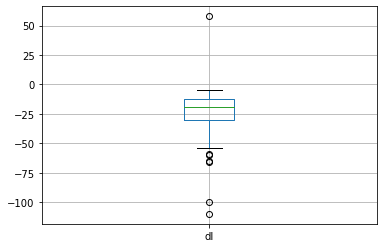

In [3]:
hef_leclercq = pd.read_csv(utils.get_demo_file('hef_lengths.csv'), index_col=0)
hef_dl = hef_leclercq.diff()[1:]
hef_dl.loc[1939:].boxplot()

In [5]:
hef_dl.loc[1939:].describe()

,dl
count,65.000000
mean,-24.676923
std,23.499407
min,-110.000000
25%,-30.000000
50%,-19.000000
75%,-12.000000
max,58.000000


In [6]:
abs(hef_dl.loc[1939:]).describe()

,dl
count,65.000000
mean,26.461538
std,21.436736
min,5.000000
25%,12.000000
50%,20.000000
75%,31.000000
max,110.000000


**Symmetry**

In [51]:
var = ''
data = list()
variables = ['volume', 'area', 'length',]
models = ['vas', 'fl']
temp_biases = [+0.5, -0.5]
for var in variables:
    data_ = list()
    for m in models:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            eq_var = ds_sel.sel(normalized=False, time=1000)[var].values
            init_var = ds_sel.sel(normalized=False, time=0)[var].values
            data__.append(abs(eq_var - init_var))
        data_.append(f'{rel_dif(*data__)*100:.0f}%')
    data.append(data_)
    
symmetry = pd.DataFrame(data, index=variables, columns=models).T.sort_index(level=0, sort_remaining=False, ascending=True)
symmetry.T

,fl,vas
volume,52%,7%
area,35%,3%
length,7%,2%


**Initial values**

Compute and show the initial values.

800074327.49
8007343.42
6900.00
596297884.17
8036000.00
4894.64


(0.0, 10.0)

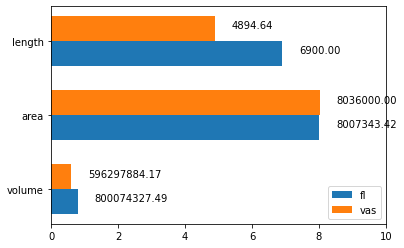

In [28]:
model = 'vas', 'flowline'
for i, model in enumerate(models[::-1]):
    ds_plot = ds.sel(normalized=False, time=0, mb_model='constant', temp_bias=0, model=model)
    x = np.array([0,1.5,3])+0.25+i*0.5
    values = ds_plot.volume, ds_plot.area, ds_plot.length
    height = ds_plot.volume/1e9, ds_plot.area/1e6, ds_plot.length/1e3
    plt.barh(x, height, label=model, height=0.5)

    for x_, y, v in zip(x, height, values):
        plt.text(y + 0.5, x_, '{:.2f}'.format(v.values), rotation=0)
        print('{:.2f}'.format(v.values))
    
plt.legend(loc=4)
plt.yticks([0.5, 2, 3.5], variables)
plt.xlim([0, 10])